In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import sklearn
import itertools
import random
from sklearn.metrics import classification_report
from keras.applications import *
from keras.layers import *
from keras.models import Model, load_model
from keras.optimizers import Adam
from sklearn.utils import class_weight
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.xception import preprocess_input as base_preprocess
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, RocCurveDisplay, auc
from sklearn.utils.multiclass import unique_labels
from collections import Counter
from pathlib import Path
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

Load data

In [ ]:
data = np.load ('/content/drive/MyDrive/CelebDf-v2/data.npy',mmap_mode='r')
labels = np.load ('/content/drive/MyDrive/CelebDf-v2/labels.npy',mmap_mode='r')

In [ ]:
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)

Data shape: (14048, 224, 224, 3)
Labels shape: (14048, 2)


Loading Images from the data

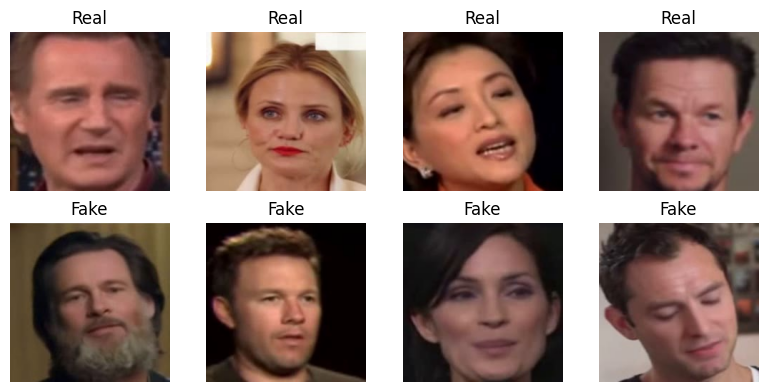

In [ ]:
# Get unique class labels and their corresponding indices in the data array
unique_classes = np.unique(labels, axis=0)

# Create a dictionary to store four random data samples from each class
class_samples = {}

# Map class indices to their corresponding names
class_names = {0: "Fake", 1: "Real"}

# Select four random data samples from each class
for class_label in unique_classes:
    class_indices = np.where(np.all(labels == class_label, axis=1))[0]
    random_indices = np.random.choice(class_indices, 4, replace=False)  # Randomly select 4 indices
    for index in random_indices:
        if tuple(class_label) in class_samples:
            class_samples[tuple(class_label)].append(data[index])
        else:
            class_samples[tuple(class_label)] = [data[index]]

# Plot the randomly selected images in 2 rows and 4 columns
plt.figure(figsize=(8, 4))  # Adjust figure size as needed
for i, (class_label, image_data_list) in enumerate(class_samples.items()):
    class_index = np.argmax(class_label)  # Get the index of the class
    class_name = class_names[class_index]  # Get the corresponding class name
    for j, image_data in enumerate(image_data_list):
        plt.subplot(2, 4, i * 4 + j + 1)
        plt.imshow(image_data)
        plt.title(f'{class_name}')
        plt.axis('off')

plt.tight_layout()
plt.show()

Frequency of the data

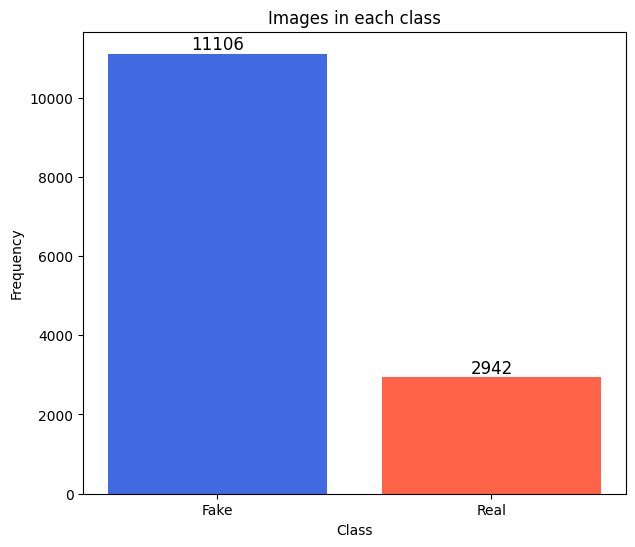

In [ ]:
# Sum the one-hot encoded labels along the rows to get the frequency of each class
class_counts = np.sum(labels, axis=0)

# Map class indices to their corresponding names
class_names = {0: "Fake", 1: "Real"}

# Define custom colors for each class
colors = ['royalblue', 'tomato']

# Plot the class frequencies with custom colors
plt.figure(figsize=(7, 6))
bars = plt.bar([class_names[class_idx] for class_idx in range(len(class_names))], class_counts, color=colors)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Images in each class')

# Annotate the bars with the class frequencies (integer format)
for bar, count in zip(bars, class_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, count, str(int(count)), ha='center', va='bottom', fontsize=12)

plt.show()

Split data

In [ ]:
# Split the data into train, test, and validation sets
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.1, stratify = labels, random_state = 42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.1, stratify = train_labels, random_state = 42)

Data Frequency of Train, Test, and Validation

In [ ]:
print("train_data shape:", train_data.shape)
print("train_labels shape:", train_labels.shape)
print("val_data shape:", val_data.shape)
print("val_labels shape:", val_labels.shape)
print("test_data shape:", test_data.shape)
print("test_labels shape:", test_labels.shape)

train_data shape: (11378, 224, 224, 3)
train_labels shape: (11378, 2)
val_data shape: (1265, 224, 224, 3)
val_labels shape: (1265, 2)
test_data shape: (1405, 224, 224, 3)
test_labels shape: (1405, 2)


Data Frequency of Each Class

In [ ]:
class_names_mapping = { 0: "Fake", 1: "Real" }
# Calculate class distribution in each set
num_classes = train_labels.shape[1]
class_counts_train = np.sum(train_labels, axis=0)
class_counts_val = np.sum(val_labels, axis=0)
class_counts_test = np.sum(test_labels, axis=0)

class_counts_mapping = {}
for index, class_name in class_names_mapping.items():
    class_counts_mapping[class_name] = {'Train': class_counts_train[index]}

for index, class_name in class_names_mapping.items():
    class_counts_mapping[class_name]['Validation'] = class_counts_val[index]

for index, class_name in class_names_mapping.items():
    class_counts_mapping[class_name]['Test'] = class_counts_test[index]

# Print class distribution mapping
for class_name, counts in class_counts_mapping.items():
    print(class_name)
    for set_name, count in counts.items():
        print(f" - {set_name}: {count}")

Fake
 - Train: 8995.0
 - Validation: 1000.0
 - Test: 1111.0
Real
 - Train: 2383.0
 - Validation: 265.0
 - Test: 294.0


Class Weight

In [ ]:
# Convert one-hot encoded labels to class labels
train_labels_encoded = np.argmax(train_labels, axis=1)

# Initialize the label encoder
label_encoder = LabelEncoder()

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels_encoded), y=train_labels_encoded)

# Create a dictionary of class weights to use in your model training
class_weight_dict = dict(enumerate(class_weights))

class_weight_dict

{0: 0.6324624791550861, 1: 2.3873268988669745}

Callback Functions

In [ ]:
lr_reduce = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.5, patience = 5,mode='max', min_lr = 1e-4,verbose = 1)
#early_stop = EarlyStopping(monitor = "val_loss", patience = 5, verbose=1)
saved_model = ('/content/drive/MyDrive/Model/Xception.h5')
model_chkpt = ModelCheckpoint(saved_model ,save_best_only = True, monitor = 'val_accuracy',verbose = 1)

# callback_list = [early_stop, model_chkpt, lr_reduce]
callback_list = [model_chkpt, lr_reduce]

XceptionNet Model

In [ ]:
base_model = Xception(weights='imagenet',
                      include_top=False,
                      input_shape=(224, 224, 3))

83683744/83683744 [==============================] - 3s 0us/step


Model's Layers

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

# Create the final model with custom classification layers
model = Model(inputs=base_model.input, outputs=predictions)


# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

Model Training

In [ ]:
epochs = 20
batch_size = 16

In [ ]:
history = model.fit(train_data, train_labels, batch_size=batch_size,
                    validation_data=(val_data, val_labels),
                    epochs=epochs,
                    callbacks=callback_list,
                    class_weight = class_weight_dict)

Epoch 1/20
712/712 [==============================] - ETA: 0s - loss: 0.5677 - accuracy: 0.6626
Epoch 1: val_accuracy improved from -inf to 0.82451, saving model to /content/drive/MyDrive/Model/Xception.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


712/712 [==============================] - 221s 252ms/step - loss: 0.5677 - accuracy: 0.6626 - val_loss: 1.1302 - val_accuracy: 0.8245 - lr: 0.0010
Epoch 2/20
712/712 [==============================] - ETA: 0s - loss: 0.3173 - accuracy: 0.8733
Epoch 2: val_accuracy improved from 0.82451 to 0.94150, saving model to /content/drive/MyDrive/Model/Xception.h5
712/712 [==============================] - 180s 253ms/step - loss: 0.3173 - accuracy: 0.8733 - val_loss: 0.1523 - val_accuracy: 0.9415 - lr: 0.0010
Epoch 3/20
712/712 [==============================] - ETA: 0s - loss: 0.2042 - accuracy: 0.9237
Epoch 3: val_accuracy did not improve from 0.94150
712/712 [==============================] - 175s 246ms/step - loss: 0.2042 - accuracy: 0.9237 - val_loss: 3.8183 - val_accuracy: 0.2285 - lr: 0.0010
Epoch 4/20
712/712 [==============================] - ETA: 0s - loss: 0.1628 - accuracy: 0.9325
Epoch 4: val_accuracy did not improve from 0.94150
712/712 [==============================] - 175s 245ms

In [ ]:
model= load_model(saved_model)

Loss Curve

Text(0.5, 1.0, 'Training and validation loss')

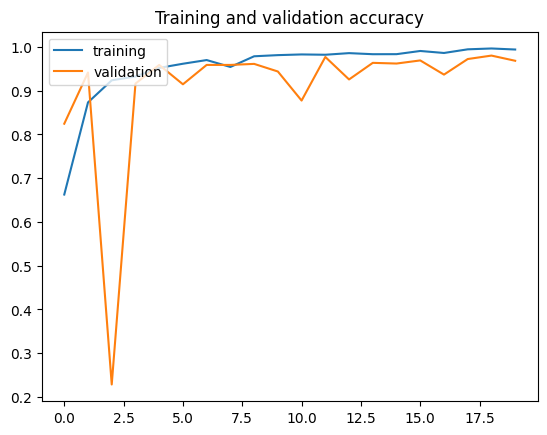

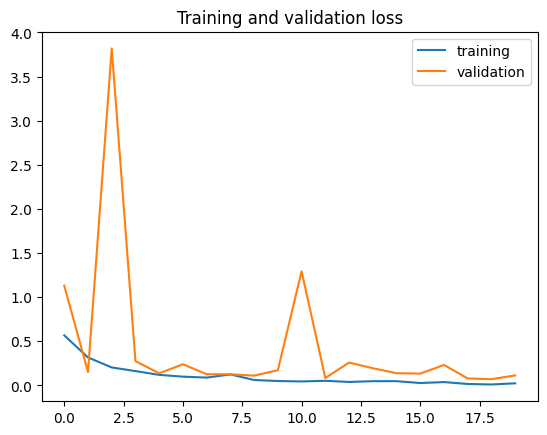

In [ ]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')

Test Accuracy

In [ ]:
test_loss, test_accuracy = model.evaluate(test_data, test_labels)
print("Test Accuracy:", test_accuracy)

44/44 [==============================] - 10s 166ms/step - loss: 0.0654 - accuracy: 0.9786
Test Accuracy: 0.9786477088928223


Classification Report

In [ ]:
# Make predictions on the test data
predictions = model.predict(test_data)

# Convert predictions and true labels to integer format
predicted_labels = np.argmax(predictions, axis=1)
# test_labels = test_data.classes
true_labels = np.argmax(test_labels, axis=1)

# Calculate the classification report
report = classification_report(true_labels, predicted_labels)

# Print the classification report
print("Classification Report:")
print(report)

44/44 [==============================] - 6s 132ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1111
           1       0.96      0.94      0.95       294

    accuracy                           0.98      1405
   macro avg       0.97      0.96      0.97      1405
weighted avg       0.98      0.98      0.98      1405



Confusion Matrix

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(true_labels, np.round(predicted_labels))

cm

array([[1099,   12],
       [  18,  276]])

Confusion matrix, without normalization


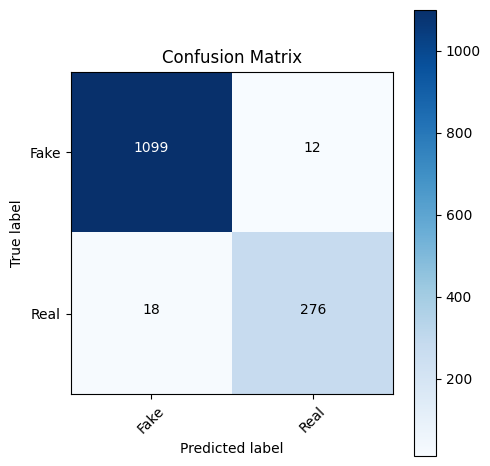

In [ ]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    print('Confusion matrix, without normalization')

    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'  # Remove '.2f' format for non-normalized values
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm_plot_labels = ["Fake", "Real"]

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')
plt.show()

ROC-AUC curve

44/44 [==============================] - 6s 136ms/step


IndexError: ignored

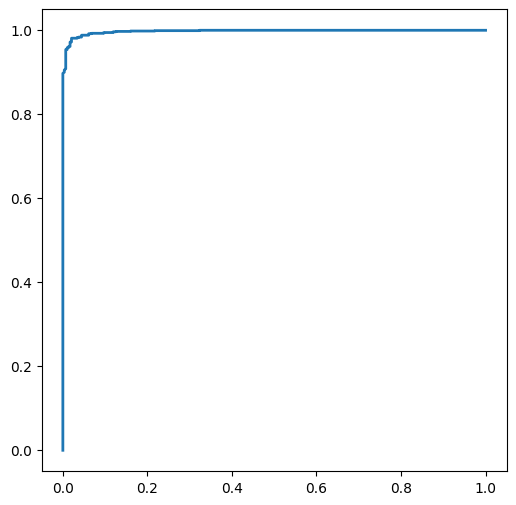

In [ ]:
# Define class names
class_names = ["Fake"]

# Make predictions on the test data
predictions = model.predict(test_data)

# Get the number of classes
num_classes = test_labels.shape[1]

# Initialize a figure to plot ROC curves
plt.figure(figsize=(6, 6))

# Loop through each class
for class_index in range(num_classes):
    # Compute ROC curve and ROC AUC for the current class
    fpr, tpr, thresholds = roc_curve(test_labels[:, class_index], predictions[:, class_index])
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve for the current class
    plt.plot(fpr, tpr, lw=2, label=f'{class_names[class_index]} (AUC = {roc_auc:.2f})')

# Plot the diagonal line (random chance)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

# Set plot properties
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Multiclass')
plt.legend(loc='lower right')

# Display the plot
plt.show()

## Explainable AI (XAI)

In [ ]:
!pip install tf-keras-vis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 2.0 MB/s eta 0:00:00


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from tensorflow.python.client import device_lib
device_list = device_lib.list_local_devices()
gpus = [device.name for device in device_list if device.device_type == 'GPU']
print('TensorFlow recognized {} GPUs'.format(len(gpus)))

TensorFlow recognized 1 GPUs


Random Image

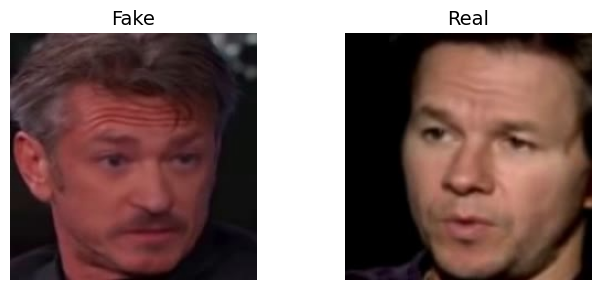

In [ ]:
binary_labels = ["Fake", "Real"]

# Convert one-hot encoded labels to integer labels
test_labels_int = np.argmax(test_labels, axis=1)

# Create an array to store the images
image_array = []

# Create subplots for 2 images in a single row (1 real and 1 fake)
num_images = 2
fig, ax = plt.subplots(1, num_images, figsize=(7, 3))

for i in range(2):  # Loop through binary classes: "Real" and "Fake"
    # Find indices of images for the current class
    class_indices = np.where(test_labels_int == i)[0]
    random_index = np.random.choice(class_indices, 1, replace=False)  # Choose 1 random index

    # Display the image from test data
    img = test_data[random_index[0]]
    image_array.append(img)  # Store the image in the array

    ax[i].imshow(img)
    ax[i].set_title(binary_labels[i], fontsize=14)
    ax[i].axis('off')

plt.tight_layout()
plt.show()

# Now you can preprocess the image_array as needed with base_preprocess function
X = base_preprocess(np.array(image_array))

In [ ]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

replace2linear = ReplaceToLinear()

# Instead of using the ReplaceToLinear instance above,
# you can also define the function from scratch as follows:
def model_modifier_function(cloned_model):
    cloned_model.layers[-1].activation = tf.keras.activations.linear

In [ ]:
from tf_keras_vis.utils.scores import CategoricalScore

# 1 is the imagenet index corresponding to Goldfish, 294 to Bear and 413 to Assault Rifle.
score = CategoricalScore([0, 1])

# Instead of using CategoricalScore object,
# you can also define the function from scratch as follows:
def score_function(output):
    # The `output` variable refers to the output of the model,
    # so, in this case, `output` shape is `(3, 1000)` i.e., (samples, classes).
    return (output[0][1])

SmoothGrad

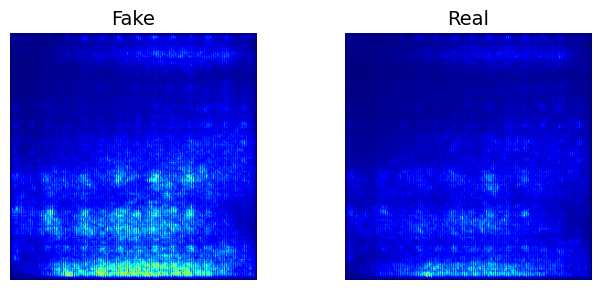

CPU times: user 5.39 s, sys: 182 ms, total: 5.57 s
Wall time: 8.15 s


In [ ]:
%%time
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency

# Create Saliency object.
saliency = Saliency(model, model_modifier=replace2linear, clone=True)

# Generate saliency maps with smoothing that reduces noise by adding noise
saliency_maps = saliency(score,
                         X,
                         smooth_samples=20,
                         smooth_noise=0.20)

# Calculate the number of images
num_images = len(binary_labels)

# Create a single row plot
# fig, axes = plt.subplots(1, num_images, figsize=(7, 3))
f, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
for i, title in enumerate(binary_labels):
    axes[i].set_title(title, fontsize=14)
    axes[i].imshow(saliency_maps[i], cmap='jet')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


GradCAM

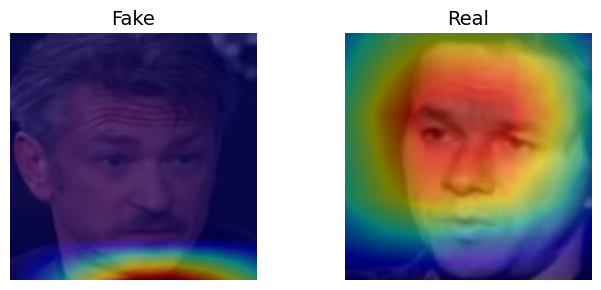

CPU times: user 2.53 s, sys: 263 ms, total: 2.79 s
Wall time: 2.88 s


In [ ]:
%%time

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

# Create Gradcam object
gradcam = Gradcam(model,
                  model_modifier=replace2linear,
                  clone=True)

# Generate heatmap with GradCAM
cam = gradcam(score,
              X,
              penultimate_layer=-1)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# cam = normalize(cam)

# Render
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
for i, title in enumerate(binary_labels):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(image_array[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

GradCAM++

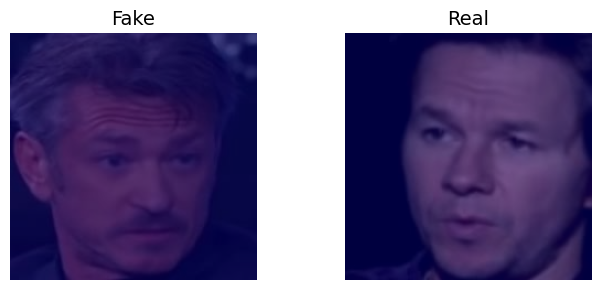

CPU times: user 1.72 s, sys: 162 ms, total: 1.88 s
Wall time: 1.72 s


In [ ]:
%%time

from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus

# Create GradCAM++ object
gradcam = GradcamPlusPlus(model,
                          model_modifier=replace2linear,
                          clone=True)

# Generate heatmap with GradCAM++
cam = gradcam(score,
              X,
              penultimate_layer=-1)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# cam = normalize(cam)

# Render
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
for i, title in enumerate(binary_labels):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(image_array[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.show()

Faster-ScoreCAM

1/1 [==============================] - 2s 2s/step


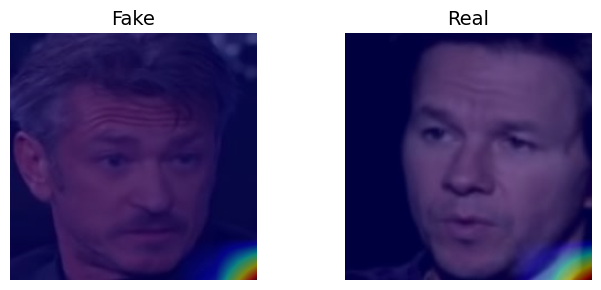

CPU times: user 3.73 s, sys: 184 ms, total: 3.91 s
Wall time: 3.76 s


In [ ]:
%%time

from tf_keras_vis.scorecam import Scorecam

# Create ScoreCAM object
scorecam = Scorecam(model, model_modifier=replace2linear)

# Generate heatmap with Faster-ScoreCAM
cam = scorecam(score,
               X,
               penultimate_layer=-1,
               max_N=10)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# cam = normalize(cam)

# Render
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
for i, title in enumerate(binary_labels):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(image_array[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.show()